# WorldMet vs AEMET

Comparar los datos que se optienen mediante `worldmet` que proceden de [NOAA](https://www.noaa.gov/) con los que se obtienen desde la API de [AEMET](https://opendata.aemet.es/centrodedescargas/inicio). La variables que se obtienen mediante las distintas fuentes no son las mismas, por lo que la comparacion se realiza entre variables comunes. Para este caso se han escogido: _Velocidad del viento_, _temperatura_, _precipitacion_, _radiacion_ y _Humedad_.

Hay que tener en cuenta que mientras que `worldmet` te permite obtener los datos con resolucion horaria, AEMET solo te permite tener los datos diarios, por lo que se debera hacer la media diaria a los datos de `worldmet` para una correcta comparacion, aunque no se sabe el metodo utilizado por AEMET para obtener los datos diarios.

|     Variable      |  AEMET   | WorldMet |
|:-----------------:|:--------:|:--------:|
| Temperatura media |   tmed   | air_temp |
| Velocidad Viento  | velmedia |    ws    |
| Direccion viento  |   dir    |    wd    |
|  Precipitacion    |   prec   |  precip  |
|    Radiacion      |   sol    |    -     |
| Humedad Relativa  |    -     |    RH    |

La compracion entre ambos datasets se realiza con los datos de la estacion meteorologica de SANTANDER AEROPUERTO.

In [1]:
setwd("~/Repositories/AirQualityCOVID")

source("src/general.R")
source("src/Curation/general.R")

In [2]:
suppressMessages(library(repr))
options(repr.plot.width=25,
        repr.plot.height=10,
        #repr.plot.pointsize=50,
        repr.plot.family='serif'
       )

In [3]:
suppressMessages(library(worldmet))
suppressMessages(library(lubridate))
suppressMessages(library(tidyverse))

## Datos de WorldMet

In [4]:
variables.wmt <- c("wd", "ws")

```R
getMeta(lat = 43.42706, 
        lon = -3.82006, 
        end.year = "current",
        n = 3, returnMap = T)
```

In [5]:
dataMto <- importNOAA(code = "080230-99999",
                      year = 2013:2020,
                      hourly = TRUE,
                      n.cores = 6
                     )

#### Medias diarias de las variables de estudio

In [6]:
library(openair)

means.dy <- timeAverage(mydata = dataMto, avg.time = "day", vector.ws = F)
new.df <- data.frame()

for (nm in variables.wmt) {
    
    new.row <- data.frame(date=means.dy$date,
                               source=rep("worldmet", nrow(means.dy)),
                               variable=rep(nm, nrow(means.dy)),
                               values=means.dy[, nm]
                              )
    names(new.row)[ncol(new.row)] <- "values"
    new.df <- rbind(new.df,
                    new.row
                   )
}

library(openair)

#timeAverage(dataMto, "daily")
dataMto = timeAverage(mydata = dataMto, avg.time = "day")
dataMto[, -c(1:4)] = scale(dataMto[, -c(1:4)])

## Datos de AEMET

In [7]:
variables.aemet <- c("dir", "velmedia")

In [8]:
data.aemet <- read.csv("data/Curation/AEMET/Values/1111.csv")
data.aemet$fecha <- ymd(data.aemet$fecha)
data.aemet <- data.aemet[-which(data.aemet$dir > 36), ]
head(data.aemet)

,fecha,indicativo,nombre,provincia,altitud,tmed,prec,tmin,horatmin,tmax,horatmax,dir,velmedia,racha,horaracha,sol,presMax,horaPresMax,presMin,horaPresMin
,<date>,<int>,<fct>,<fct>,<int>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<fct>,<int>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2016-12-31,1111,SANTANDER,CANTABRIA,52,8.1,0,5.5,07:30,10.7,10:05,16,1.9,4.7,-2,7.2,1026.0,0,1022.4,24
2,2017-01-01,1111,SANTANDER,CANTABRIA,52,9.2,0,5.5,06:20,12.8,13:00,20,2.5,6.1,07:28,7.2,1022.4,0,1011.0,24
3,2017-01-02,1111,SANTANDER,CANTABRIA,52,10.2,0,6.5,02:00,14.0,-2,18,4.7,10.0,06:35,5.9,1015.0,24,1010.2,6
4,2017-01-03,1111,SANTANDER,CANTABRIA,52,8.4,0,6.3,07:55,10.5,12:15,9,6.1,12.2,02:41,7.3,1020.3,24,1014.7,0
5,2017-01-04,1111,SANTANDER,CANTABRIA,52,8.2,0,5.6,04:00,10.7,13:10,9,3.3,7.2,14:07,2.5,1022.2,24,1020.3,0
6,2017-01-05,1111,SANTANDER,CANTABRIA,52,7.8,0,5.3,07:00,10.4,13:10,9,7.2,12.8,12:30,8.8,1024.5,24,1022.2,0


In [9]:
new.df.aemet <- data.frame()

for (i in 1:length(variables.aemet)) {
    
    new.df.aemet <- rbind(new.df.aemet,
                    data.frame(date=data.aemet$fecha,
                               source=rep("aemet", 
                                          length(data.aemet[, "fecha"])),
                               variable=rep(variables.wmt[i], 
                                            length(data.aemet[, "fecha"])),
                               values=data.aemet[, variables.aemet[i]])
                   )
}

head(new.df.aemet)

,date,source,variable,values
,<date>,<fct>,<fct>,<dbl>
1,2016-12-31,aemet,wd,16
2,2017-01-01,aemet,wd,20
3,2017-01-02,aemet,wd,18
4,2017-01-03,aemet,wd,9
5,2017-01-04,aemet,wd,9
6,2017-01-05,aemet,wd,9


## Juntar Ambos dataSets

In [10]:
all.meteo <- rbind(new.df, new.df.aemet)

head(all.meteo)

,date,source,variable,values
,<dttm>,<fct>,<fct>,<dbl>
1,2013-01-01,worldmet,wd,286.6196
2,2013-01-02,worldmet,wd,334.4606
3,2013-01-03,worldmet,wd,104.8580
4,2013-01-04,worldmet,wd,124.9080
5,2013-01-05,worldmet,wd,124.7949
6,2013-01-06,worldmet,wd,109.5865


## Diferencias 

In [11]:
for (var in levels(as.factor(all.meteo$variable))) {
    data.1 <- all.meteo[all.meteo$source == "worldmet" &
                        all.meteo$variable == var, c("date", "values")]
    data.2 <- all.meteo[all.meteo$source == "aemet" &
                        all.meteo$variable == var, c("date", "values")]
    
    diff <- merge(data.1, data.2,
                  by = "date", all.x=T, all.y=T)
    
    print(paste(var, mean((diff$values.x - diff$values.y), na.rm=TRUE), sep=" => "))
}

[1] "wd => 178.134150390399"
[1] "ws => 0.302495806220324"


## Representar ambos datasets

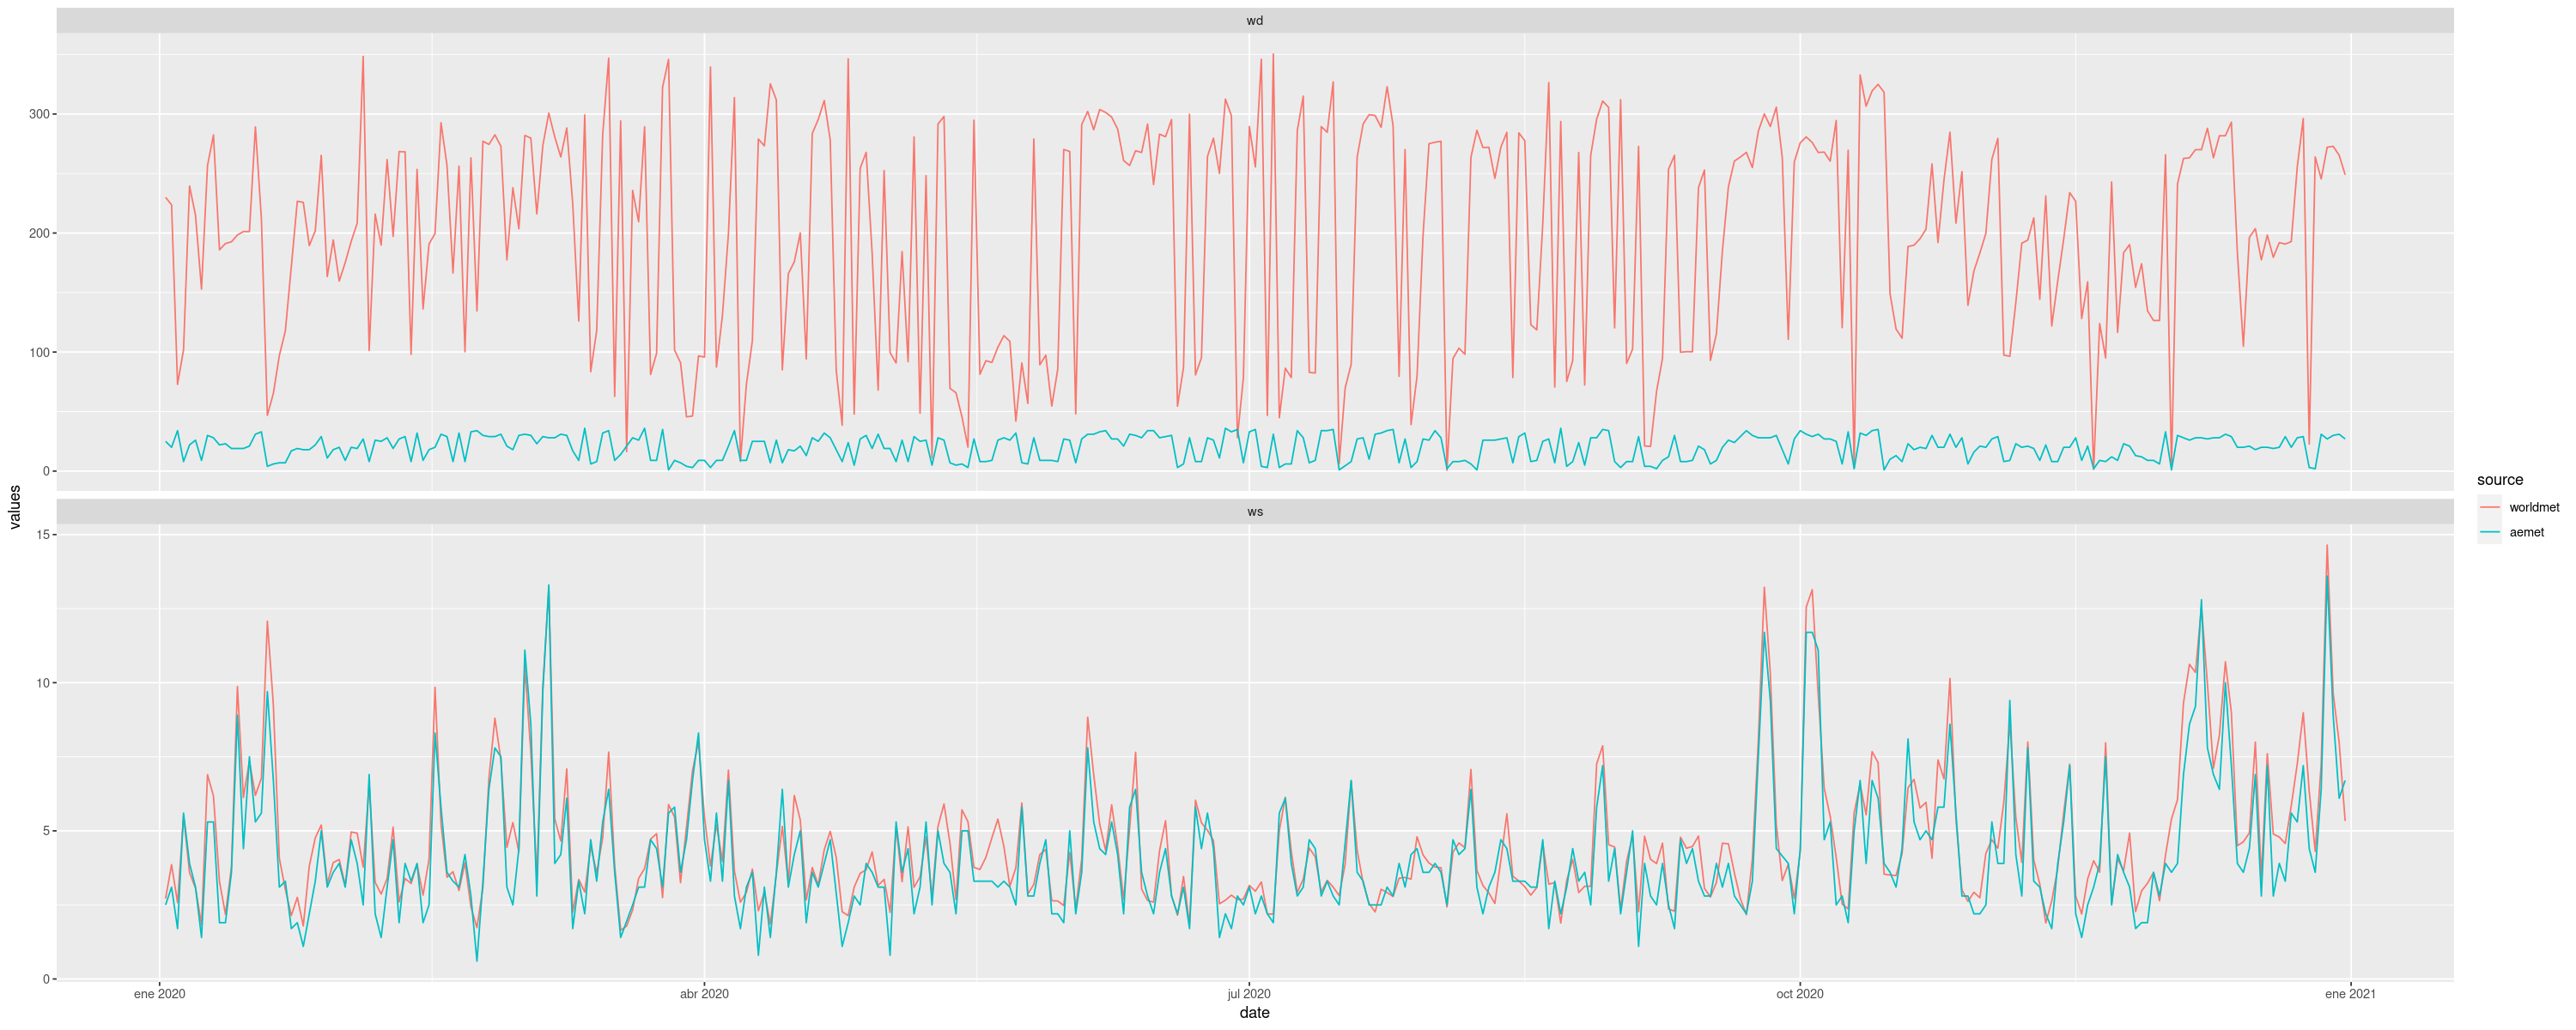

In [12]:
ggplot(data=all.meteo[all.meteo$date > ymd("2020-01-01"),]) +
    geom_line(aes(x=date, y=values, color=source)) + 
facet_wrap(~variable, ncol=1, scales = "free_y")

In [13]:
aemet.ws <- all.meteo[all.meteo$date >= ymd("2020-01-01") &
                   all.meteo$source == "aemet" &
                   all.meteo$variable == "ws",]
worldmet.ws <- all.meteo[all.meteo$date >= ymd("2020-01-01") &
                   all.meteo$source == "worldmet" &
                   all.meteo$variable == "ws",]

In [19]:
aemet.wd <- all.meteo[all.meteo$date >= ymd("2020-01-01") &
                   all.meteo$source == "aemet" &
                   all.meteo$variable == "wd",]
worldmet.wd <- all.meteo[all.meteo$date >= ymd("2020-01-01") &
                   all.meteo$source == "worldmet" &
                   all.meteo$variable == "wd",]

In [14]:
mean.dir <- function(data) {

    u <- data$ws * sin(2 * pi * data$wd/360)
    v <- data$ws * cos(2 * pi * data$wd/360)

    med.u <- mean(u, na.rm=T)
    med.v <- mean(v, na.rm=T)

    (atan2(med.u, med.v) * 360/(2*pi))# + 180
}

In [15]:
q <- dataMto[, c("date", "wd", "ws")]

q$date <- floor_date(q$date, "day")

mean.df <- data.frame()

for (dt in levels(as.factor(q$date))) {
    
        b <- mean(q[q$date == ymd(dt),]$ws, na.rm = T)
        a <- mean.dir(q[q$date == ymd(dt),])
        mean.df <- rbind(mean.df,
                         data.frame(date=ymd(dt),
                                    ws=b,
                                    wd=a
                                   )
                        )
}

In [16]:
mean.df[which(mean.df$wd < 0),]$wd <- mean.df[which(mean.df$wd < 0),]$wd + 360
mean.df[which(mean.df$wd >= 360),]$wd <- mean.df[which(mean.df$wd >= 360),]$wd - 360

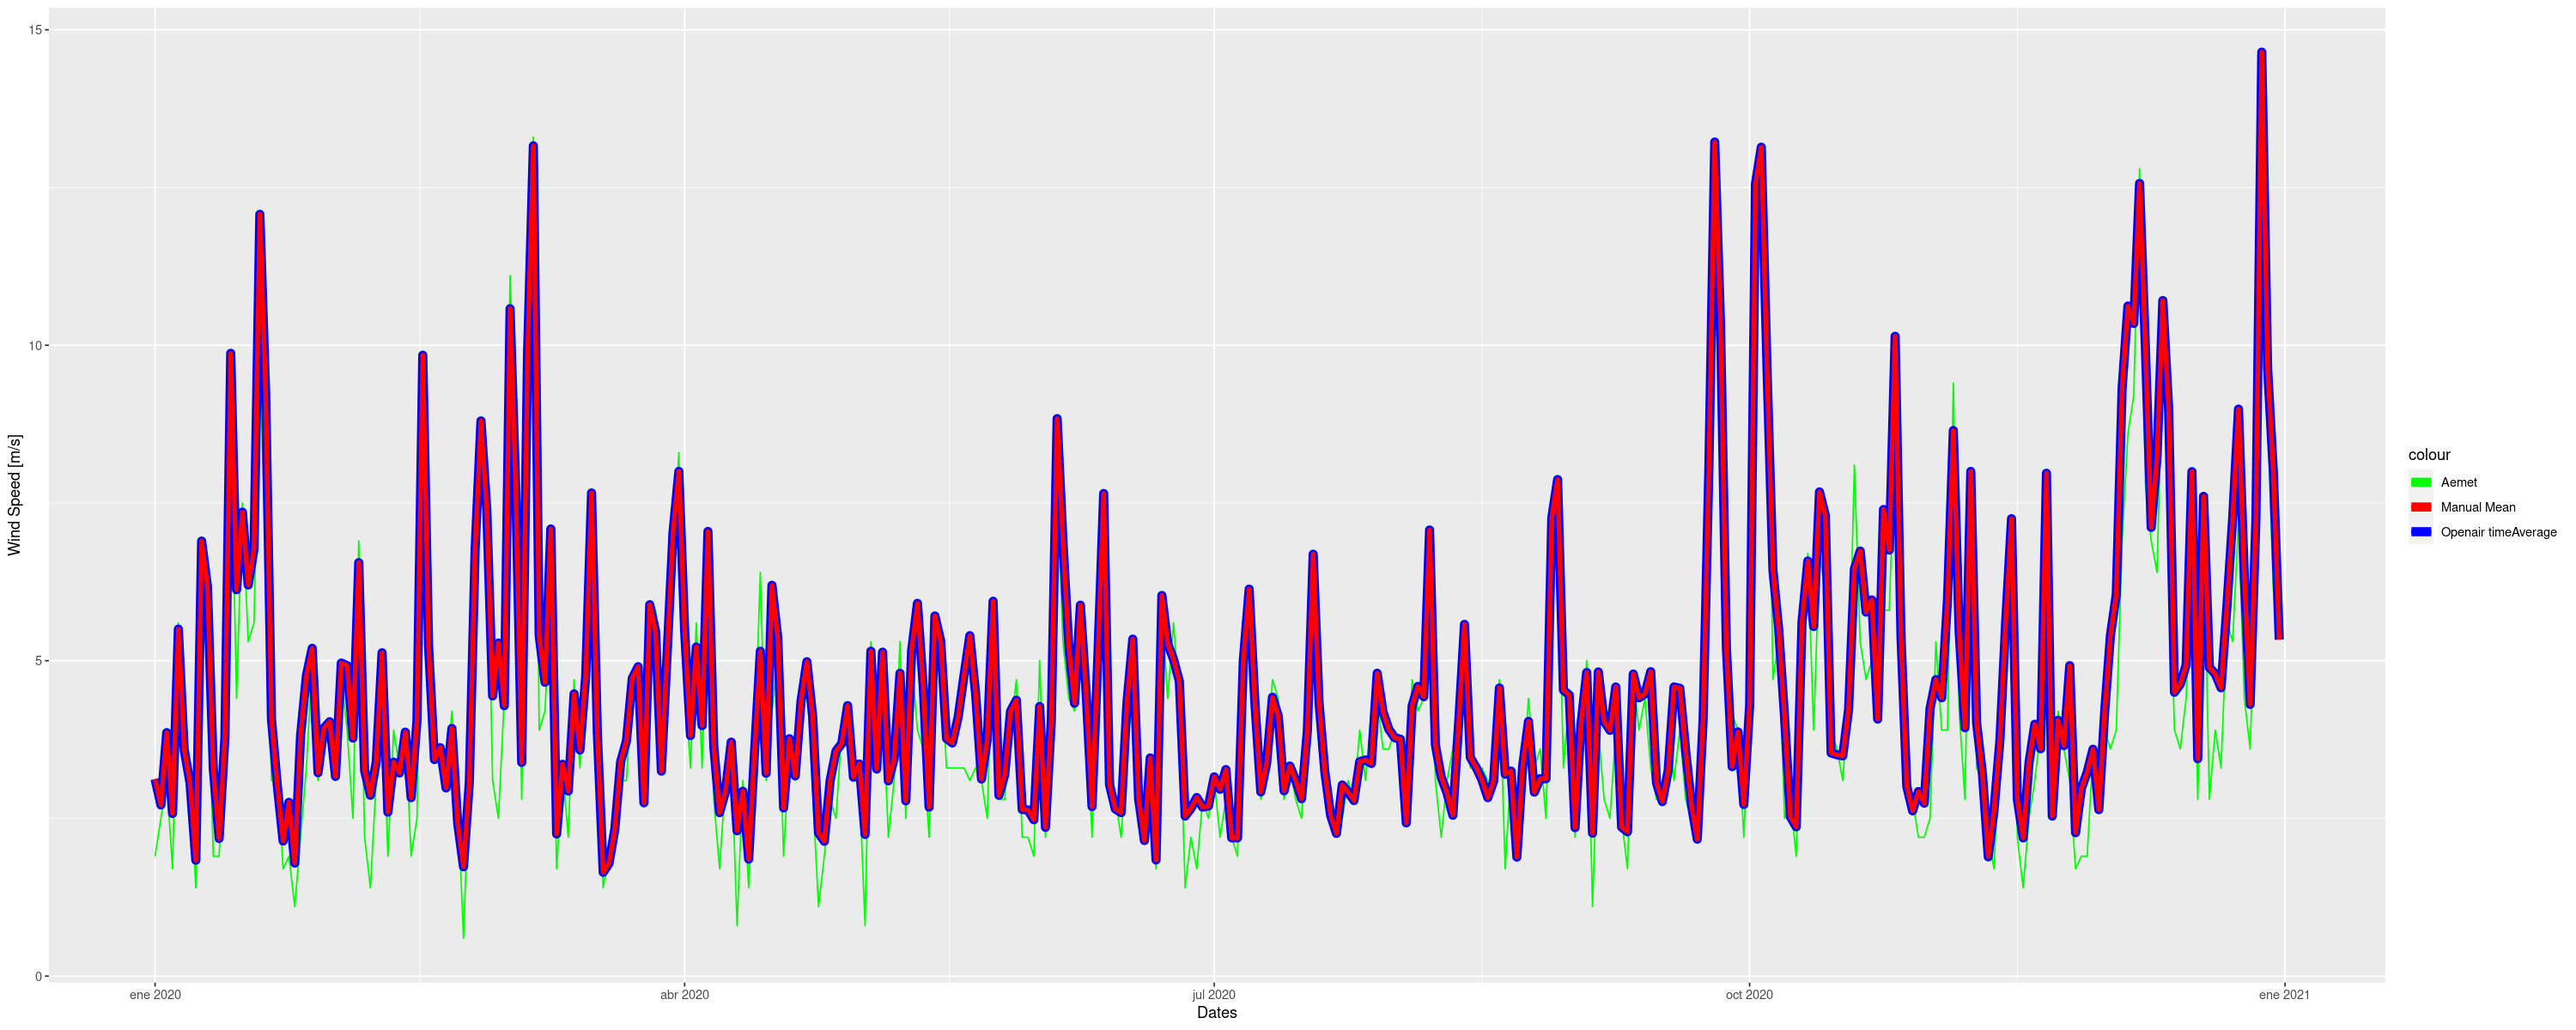

In [17]:
ggplot()  +
    scale_color_manual(values = c("Aemet"="green", "Manual Mean"="red", "Openair timeAverage"="blue"))+
    geom_line(data=aemet.ws, aes(x=ymd(date), y=values, color="Aemet")) +
    geom_line(data=worldmet.ws, aes(x=ymd(date), y=values, color="Openair timeAverage"), size=3) +
    geom_line(data=mean.df[mean.df$date >= ymd("2020-01-01"),], aes(x=date, y=ws, color="Manual Mean"), size=1.5) +

    labs(x="Dates", y="Wind Speed [m/s]")

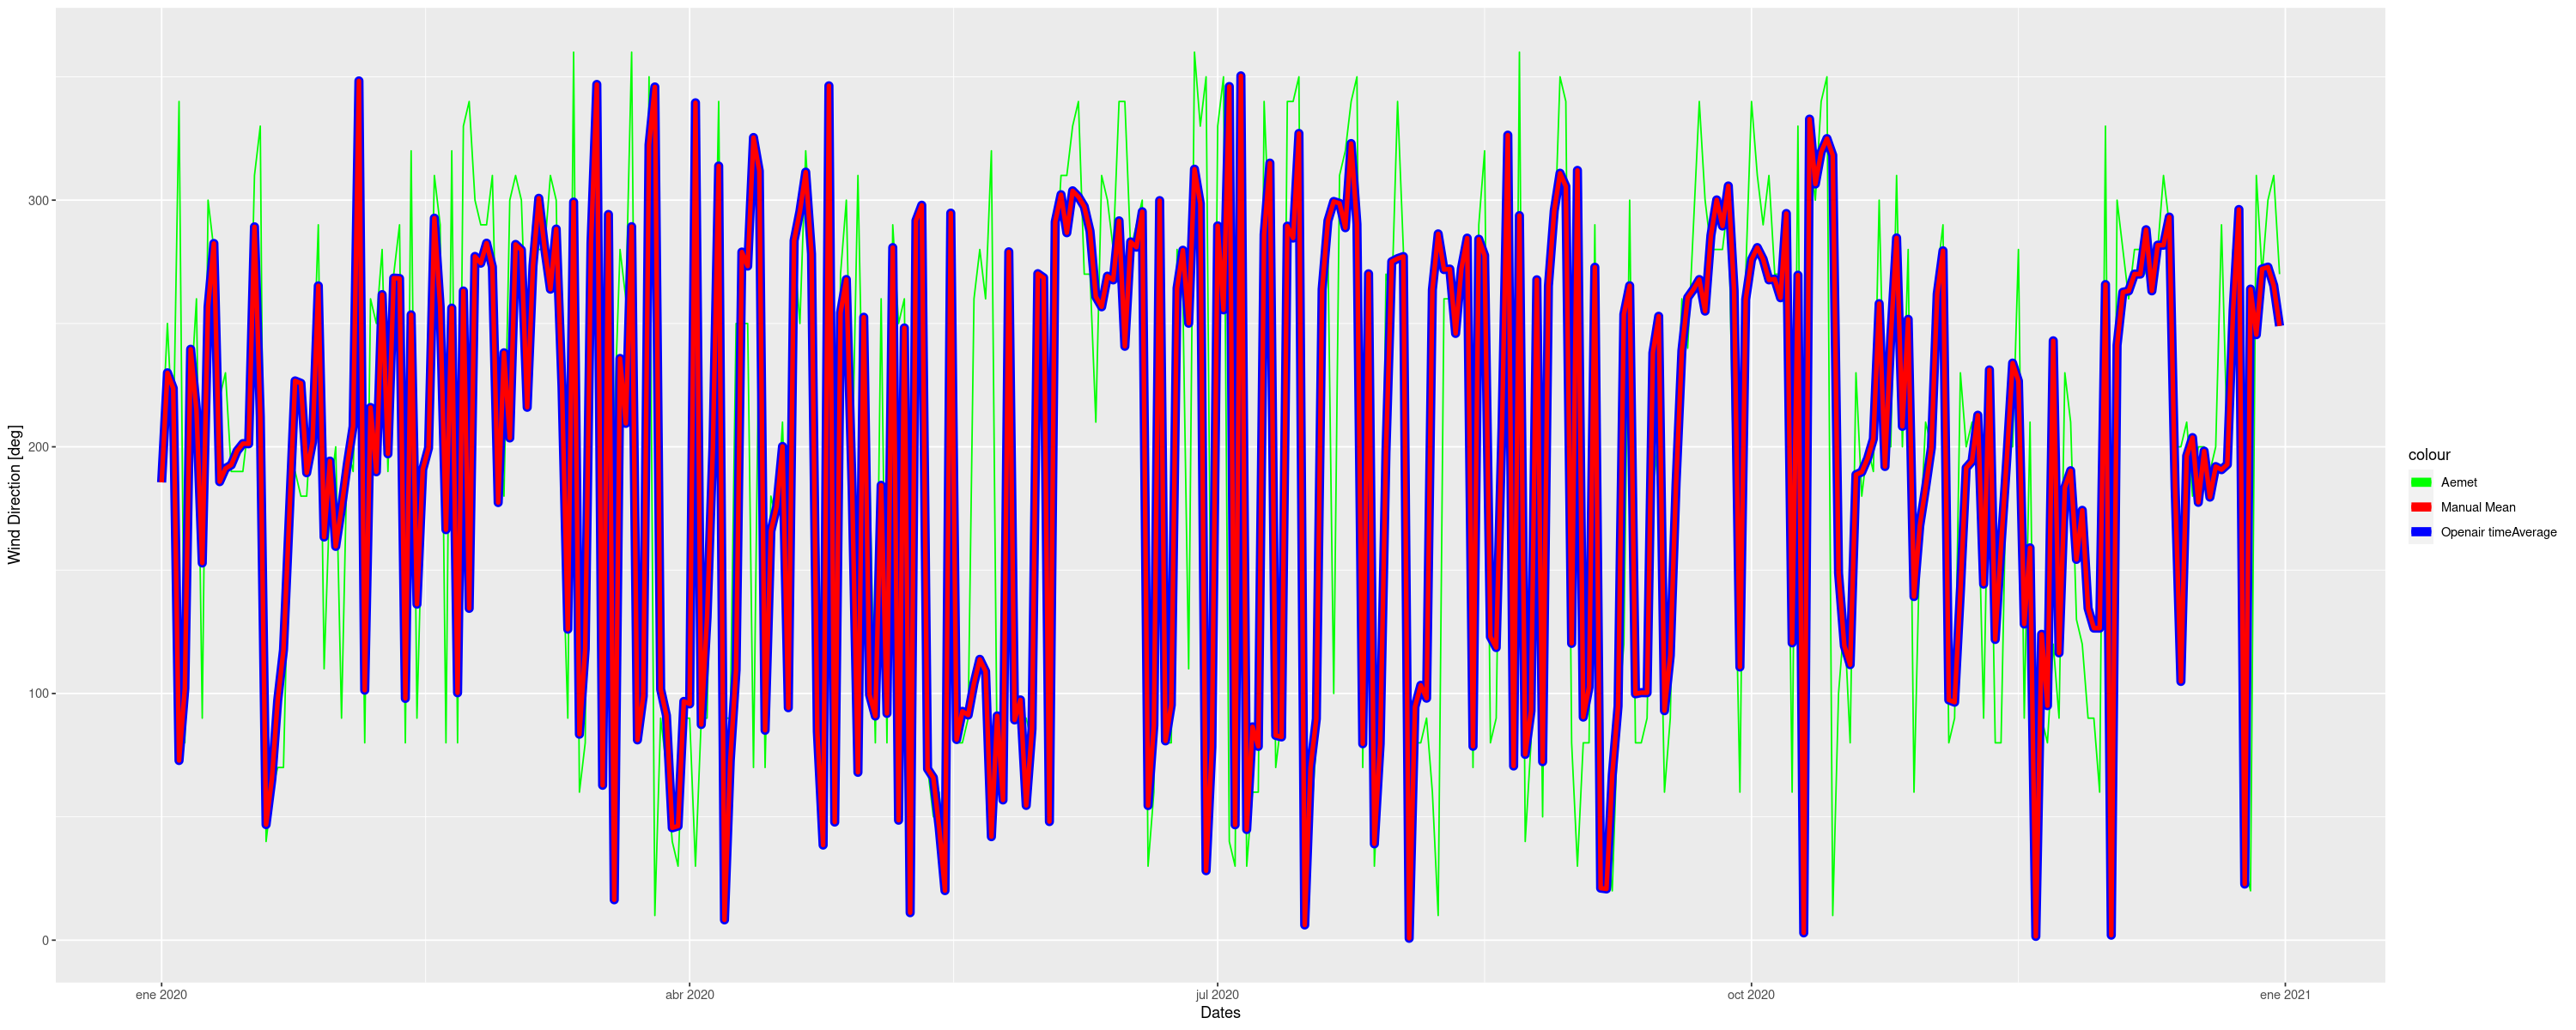

In [20]:
ggplot()  +
    scale_color_manual(values = c("Aemet"="green", "Manual Mean"="red", "Openair timeAverage"="blue"))+
    geom_line(data=aemet.wd, aes(x=ymd(date), y=values*10, color="Aemet")) +
    geom_line(data=worldmet.wd, aes(x=ymd(date), y=values, color="Openair timeAverage"), size=3) +
    geom_line(data=mean.df[mean.df$date >= ymd("2020-01-01"),], aes(x=date, y=wd, color="Manual Mean"), size=1.5) +

    labs(x="Dates", y="Wind Direction [deg]")

ggsave("Plots/Hola.png", device = "png", width = 20, height = 10)